# PSILOCYBIN MICE

THEY DIDN'T PUBLISH THE METADATA SO WE HAVE TO FLY BY THE SEAT OF OUR PANTS BUT IT SHOULD BE OK, THOSE ARE MOUSE BRAIN CELL TYPES AFTER ALL

In [1]:
import scanpy as sc
import anndata as ad

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from platython import normalise as pn
from anticor_features.anticor_features import get_anti_cor_genes
import topo as tp
from topo.tpgraph.intrinsic_dim import IntrinsicDim

In [2]:
# _psilo = sc.read_10x_mtx("/Users/npapadop/Documents/teaching/2024/GSE246451/psilo/")
# _psilo.obs.index = _psilo.obs.index.str.replace("-1", "-p")
# _psilo.obs["condition"] = "psilocybin"
_saline = sc.read_10x_mtx("/Users/npapadop/Documents/teaching/2024/GSE246451/saline/")
_saline.obs.index = _saline.obs.index.str.replace("-1", "-s")
_saline.obs["condition"] = "saline"

In [3]:
# adata = ad.concat((_psilo, _saline))
# del _psilo, _saline
adata = _saline

In [5]:
adata

AnnData object with n_obs × n_vars = 3539949 × 32285
    obs: 'condition'
    var: 'gene_ids', 'feature_types'

from the paper:

> To remove low quality cells and likely multiplet captures, we filtered out cells with features < 700, mitochondrial gene percentage > 5%, then removed doublets with DoubletFinder (v2.0.3, RRID:SCR_018771) 69. Possible estimation and removal of cell free mRNA contamination was removed with SoupX (v.1.6.0, RRID:SCR_019193) 70. Gene expression differences were identified between Saline and Psilocybin samples (N = 4/group) using DESeq2 (v1.38.0, RRID:SCR_015687) 71. The enrichment analysis was performed with clusterProfiler (v4.8.1, RRID:SCR_016884) 72 and ReactomePA (v1.44.0, RRID:SCR_019316) 73.

In [6]:
%matplotlib inline

In [7]:
sc.pp.filter_cells(adata, min_genes=700)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 11919 × 24314
    obs: 'condition', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

Identify mitochondrial genes, which are an important quality control indicator:

In [8]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [9]:
# sc.pl.violin(
#     adata,
#     ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
#     jitter=0.4,
#     multi_panel=True,
#     groupby="condition"
# )

amazing quality, we can keep all of those since we probably won't have problems.

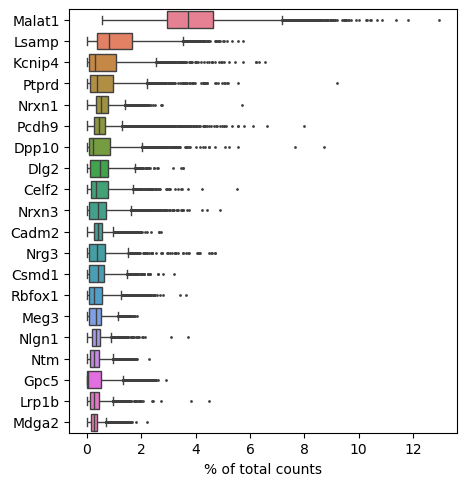

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20)

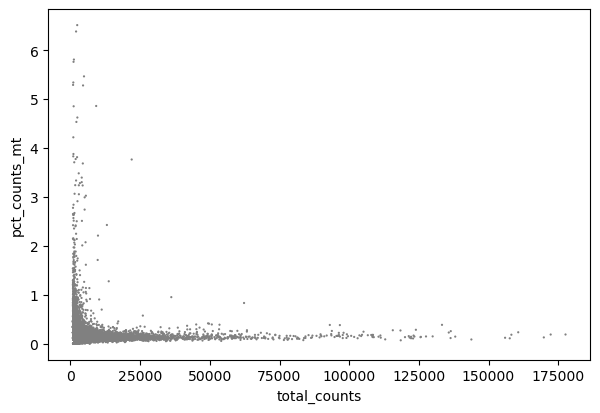

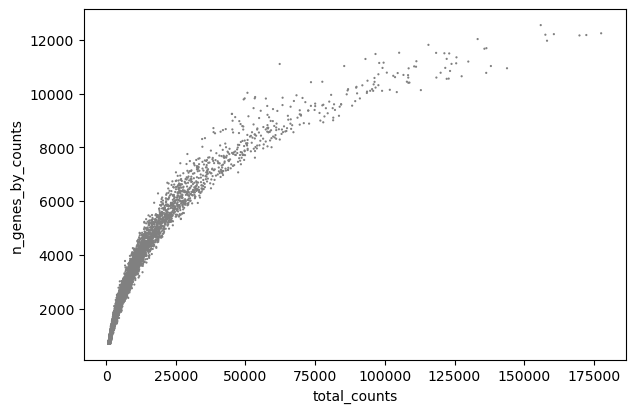

In [11]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

The points on the far right are on fraud alert, but we can deal with them later

## Normalisation

In [14]:
adata.layers["counts"] = adata.X
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.normalize_total(adata)

## Informative gene selection

In [15]:
anti_cor_table = get_anti_cor_genes(adata.X.T,
                                    adata.var.index.tolist(),
                                    species="mmusculus")

selected_table = anti_cor_table[anti_cor_table["selected"]==True]
print(selected_table)

found 741.475909632 free Gb in /var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T
get_all_remove_genes
11919 595
min_express_n 50
get_n_expressed
pathways_to_genes
    0              1    2                   3         4  \
0  g#  initial alias   c#     converted alias      name   
1   1     GO:0044429  1.1  ENSMUSG00000024120    LRPPRC   
2   1     GO:0044429  1.2  ENSMUSG00000027223  MAPK8IP1   
3   1     GO:0044429  1.3  ENSMUSG00000019370     CALM3   
4   1     GO:0044429  1.4  ENSMUSG00000042787      EXOG   

                                                   5           6  
0                                        description  namespaces  
1  leucine-rich PPR-motif containing [Source:MGI ...        None  
2  mitogen-activated protein kinase 8 interacting...        None  
3    calmodulin 3 [Source:MGI Symbol;Acc:MGI:103249]        None  
4  endo/exonuclease (5'-3'), endonuclease G-like ...        None  
get_ensg_of_ref
    0              1                   2      3                4 

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


empirically determined Cneg cutoff: -0.026976274048097968  for FPR of: 0.001
empirically determined Cpos cutoff: 0.03833159114201483  for FPR of: 0.001
get_real_spear
[0, 5000, 10000, 14888]
working on 0 5000 vs 5000 10000
	getting spearman correlation
working on 0 5000 vs 10000 14888
	getting spearman correlation
working on 5000 10000 vs 10000 14888
	getting spearman correlation


/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/anticor_features/anticor_features.py:402: RuntimeWarning: divide by zero encountered in scalar divide
  FDR_vect[i] = FP_hat_vect[i]/all_sig_neg_vect[i]


                        gene  pre_remove_feature  pre_remove_pathway  \
Xkr4                    Xkr4               False               False   
Gm1992                Gm1992               False               False   
Gm19938              Gm19938               False               False   
Sox17                  Sox17               False               False   
Rgs20                  Rgs20               False               False   
...                      ...                 ...                 ...   
Gm21887              Gm21887               False               False   
Uty                      Uty               False               False   
Gm47283              Gm47283               False               False   
4933409K07Rik  4933409K07Rik               False               False   
AC149090.1        AC149090.1               False               False   

               pre_remove_low_express  n_expressed  percent_expressed  \
Xkr4                            False       7711.0           0

In [16]:
adata.var = pd.concat([adata.var, anti_cor_table], axis=1)

## Dimensionality estimation

In [17]:
hvg = adata[:, adata.var["selected"] == True].copy()

In [18]:
hvg

AnnData object with n_obs × n_vars = 11919 × 9503
    obs: 'condition', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene', 'pre_remove_feature', 'pre_remove_pathway', 'pre_remove_low_express', 'n_expressed', 'percent_expressed', 'non_zero_mean', 'num_neg', 'num_sig_neg', 'FP_hat', 'FDR', 'num_sig_pos_cor', 'selected'
    uns: 'log1p'
    layers: 'counts'

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/topo/base/ann.py:124: UserWarning: hnswlib does not support sparse matrices. Converting to array...
  warn("hnswlib does not support sparse matrices. Converting to array...")


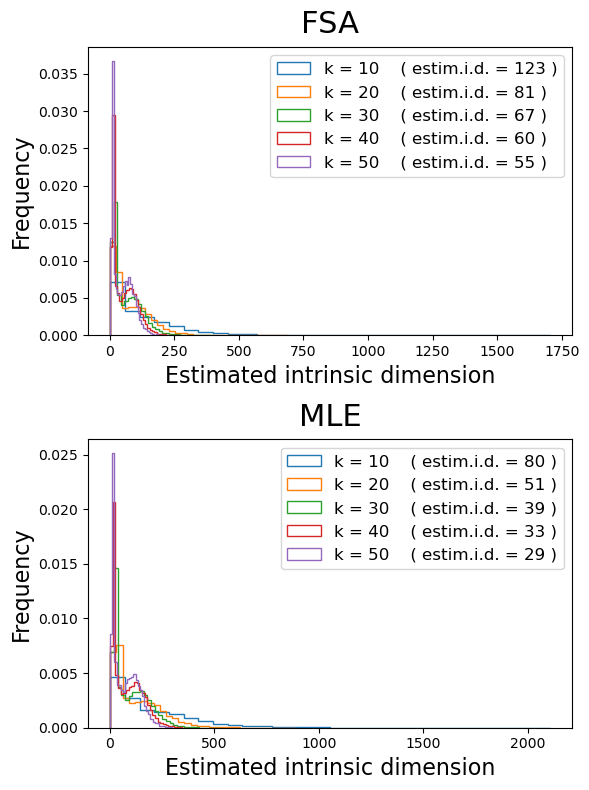

In [19]:
id_est = IntrinsicDim(
    methods=['fsa', 'mle'], # the methods we'll use
    k=range(10, 60, 10), # the number of k-neighbors to test
    backend='hnswlib',  # the approximate kNN backend to use
    metric='cosine', # the distance metric to use
    n_jobs=-1, # the number of jobs to run in parallel
    plot=True, # whether to plot the results during fit()
    random_state=None) # the random state to use for colors

# Estimate the i.d.
id_est.fit(hvg.X)

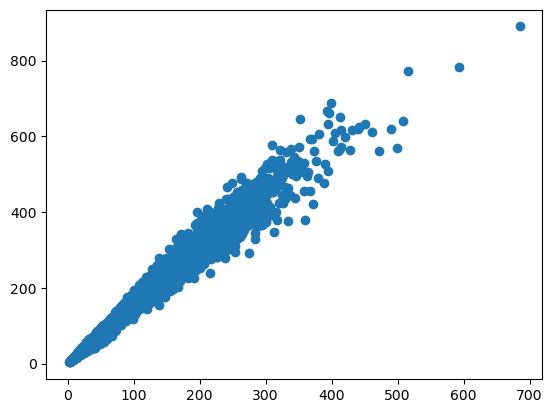

Spearman R correlation: 0.996


In [20]:
from scipy.stats import spearmanr

# Compare the results for 100 k-nearest-neighbors
fsa_local = id_est.local_id['fsa']['20']
mle_local = id_est.local_id['mle']['20']

corr, _ = spearmanr(fsa_local, mle_local)

plt.scatter(fsa_local, mle_local)
plt.show()

print('Spearman R correlation: %.3f' % corr)

In [27]:
# Create TopOGraph object using 20 kNN
tg = tp.TopOGraph(base_knn=20, 
                    n_eigs=85, # set this to the largest estimate!
                    n_jobs=-1,
                    verbosity=0)

# Run a TopOMetry model
hvg = tp.sc.topological_workflow(
    hvg,                  # the anndata object
    tg,                # the TopOGraph object
    kernels=['bw_adaptive'],# the kernel(s) to use
    eigenmap_methods=['DM'],# the eigenmap method(s) to use
    projections=['MAP'],    # the projection(s) to use
    resolution=2.0          # the Leiden clustering resolution
)

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/topo/base/ann.py:124: UserWarning: hnswlib does not support sparse matrices. Converting to array...
  warn("hnswlib does not support sparse matrices. Converting to array...")


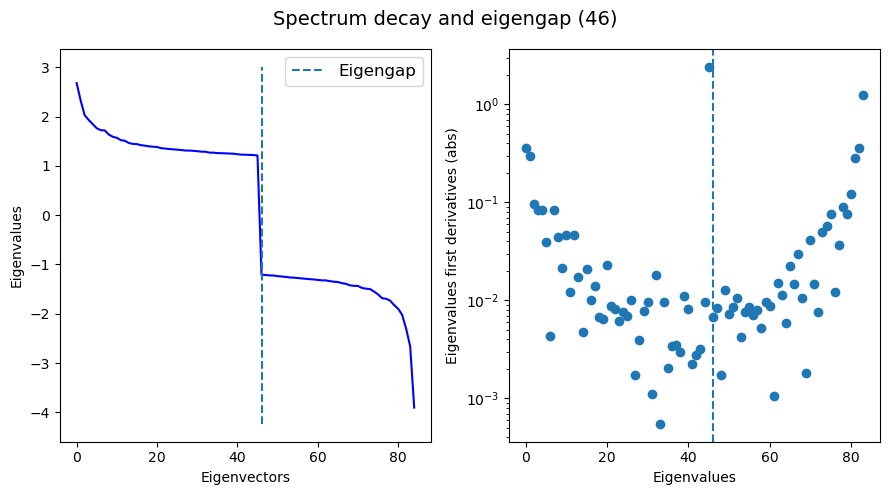

In [28]:
tg.eigenspectrum()

In [29]:
adata.uns["proposed_dimensionality"] = 50

In [30]:
from sklearn.decomposition import PCA
from umap import UMAP

sc.pp.scale(hvg, max_value=10)

pca_op = PCA(n_components=adata.uns["proposed_dimensionality"]) # compute similar amount of components for fair comparison
pca_Y = pca_op.fit_transform(hvg.X)

umap_PCA = UMAP(n_components=2, metric='cosine').fit_transform(pca_Y)

In [31]:
evaluation_dict = tp.pipes.eval_models_layouts(tg, hvg.X,
                                                    kernels=['bw_adaptive'],
                                                    eigenmap_methods=['msDM','DM','LE'],
                                                    projections=['MAP'],
                                                    additional_eigenbases={"PCA_scale": pca_Y},
                                                    additional_projections={'UMAP': umap_PCA},
                                                    n_neighbors=3,
                                                    n_pcs=adata.uns["proposed_dimensionality"],
                                                    n_jobs=-1
                                                )

In [32]:
pd.DataFrame(evaluation_dict)

,Eigenbasis - Trustworthiness,Eigenbasis - Geodesic correlation,Eigenbasis - Global score,Projection - Trustworthiness,Projection - Geodesic correlation,Projection - Global score
DM with bw_adaptive,0.901069,0.252930,0.959409,NaN,NaN,NaN
msDM with bw_adaptive,0.896597,0.217899,0.935275,NaN,NaN,NaN
LE with bw_adaptive,0.908360,-0.123626,0.955707,NaN,NaN,NaN
PCA,0.969304,0.306206,NaN,NaN,NaN,NaN
PCA_scale,0.969474,0.270867,1.000000,NaN,NaN,NaN
MAP of bw_adaptive from DM with bw_adaptive,NaN,NaN,NaN,0.865951,0.335544,0.985035
MAP of bw_adaptive from msDM with bw_adaptive,NaN,NaN,NaN,0.866463,0.291826,0.983647
MAP of bw_adaptive from LE with bw_adaptive,NaN,NaN,NaN,0.858282,0.236940,0.984022
UMAP,NaN,NaN,NaN,0.925555,0.270347,0.989861


In [33]:
# # save best embeddings
# adata.obsm["X_pca"] = pca_Y
# adata.obsm["X_dm"] = tg.EigenbasisDict['DM with bw_adaptive'].results()

# # save two best projections
# adata.obsm["X_topo"] = tg.ProjectionDict['MAP of bw_adaptive from LE with bw_adaptive']
# adata.obsm["X_umap"] = umap_PCA

# # keep track of our choices
# adata.uns["X_topo"] = 'MAP of bw_adaptive from LE with bw_adaptive'
# adata.uns["topo_eval_dict"] = evaluation_dict

In [34]:
sc.tl.pca(hvg)

In [36]:
adata.obsm["X_pca"] = hvg.obsm["X_pca"].copy()

In [37]:
sc.pp.neighbors(adata, use_rep="X_pca", n_neighbors=20, metric="cosine", n_pcs=50)
sc.tl.umap(adata)

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


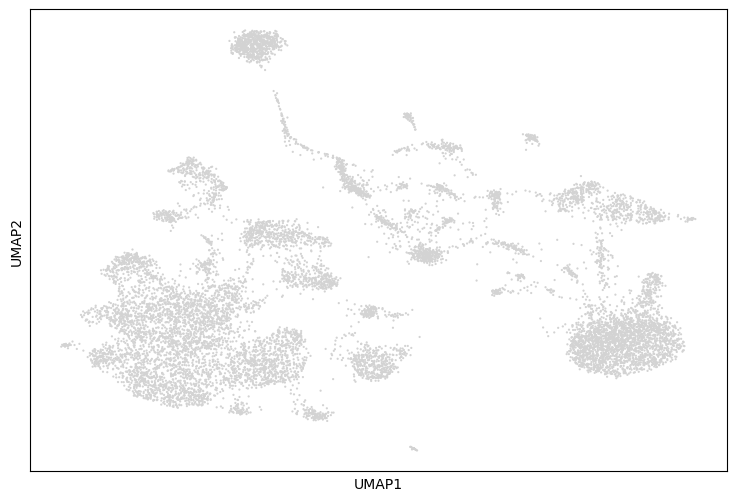

In [38]:
fig, ax = plt.subplots(figsize=(9, 6))
sc.pl.umap(adata, ax=ax)

## Cluster analysis

In [105]:
sc.tl.leiden(adata, resolution=0.47, key_added="coarse")
# pc.merge_clusters(adata, "leiden", num_genes=40)

In [106]:
adata.obs["coarse"].cat.categories.shape

(20,)

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warn

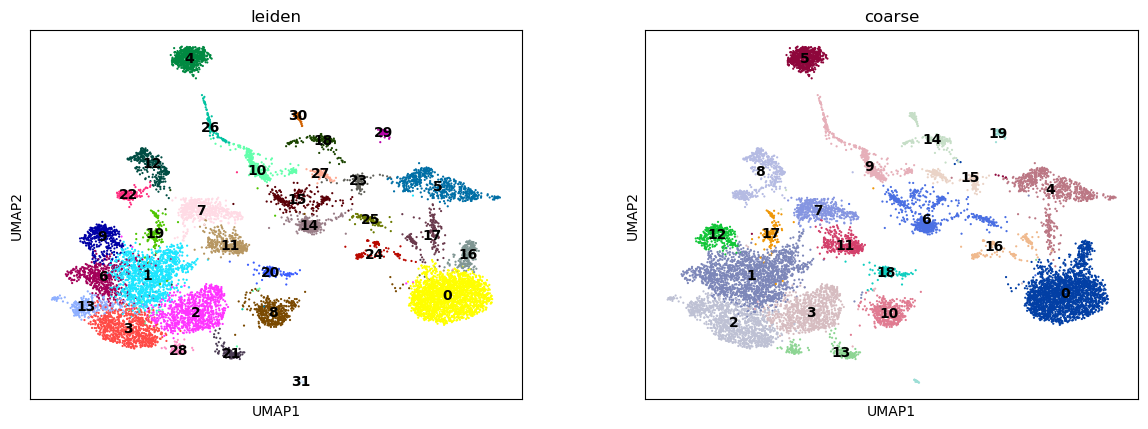

In [107]:
# fig, ax = plt.subplots(figsize=(9, 6))
sc.pl.umap(adata, color=["leiden", "coarse"], legend_loc="on data")

In [109]:
sc.tl.dendrogram(adata, groupby="coarse")

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


In [159]:
marker_genes = ["Vip", "Sst", "Pvalb", "Lamp5",
                "Gad2", "Dlx6os1", "Foxp2", "Rorb", "Il1rapl2",
                "Arhgap15", "Pld5", "Slc17a7", "Snap25",]

broad_ct = [
    "Gad2", # gabaergic
    "Slc17a7", # glutamatergic
    "Pdgfra", # OPC
    "Ptgds",
    "Opalin", # ODC
    "Mog",
    "Acsbg1", 
    "Aldh1l1", # astrocytes
    "Cx3cr1",
    "Rgs5",
    "Pecam1",
]

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cm

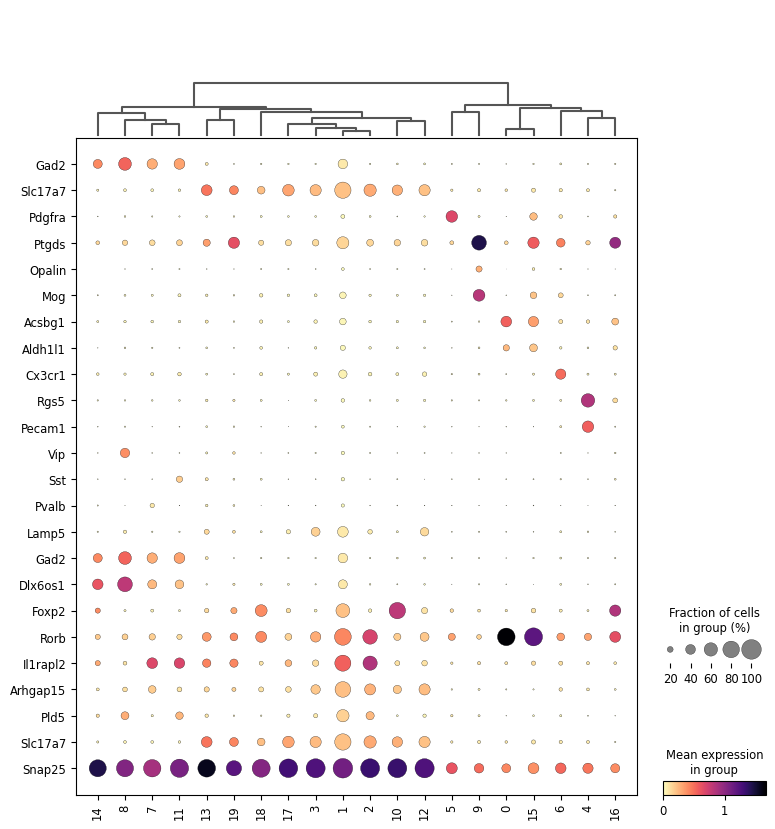

In [161]:
sc.pl.dotplot(adata, var_names=broad_ct+marker_genes, groupby="coarse", swap_axes=True, cmap="magma_r", dendrogram=True)

In [162]:
clusters = {
    "14": "GABA-Inh1",
    "8": "GABA-Vip",
    "7": "GABA-Pvalb",
    "11": "GABA-Sst",
    "1": "GABA-Lamp5",
    "13": "glut-13",
    "19": "glut-19",
    "18": "glut-Ex7",
    "17": "glut-17",
    "3": "glut-3",
    "2": "glut-Ex1",
    "10": "glut-Ex3",
    "12": "glut-12",
    "5": "OPC",
    "9": "ODC",
    "0": "astrocyte",
    "15": "astrocyte?",
    "6": "Microglia",
    "4": "Endo/SMC",
    "16": "VLMC",
}

In [164]:
adata.obs["annot"] = adata.obs["coarse"].cat.rename_categories(clusters)

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


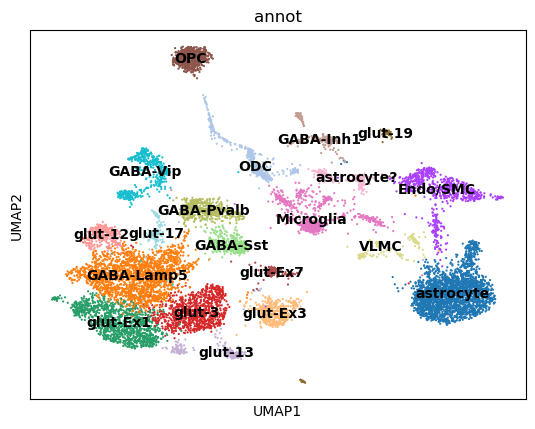

In [166]:
# fig, ax = plt.subplots(figsize=(9, 6))
sc.pl.umap(adata, color="annot", legend_loc="on data")

In [181]:
paper_order = ['glut-Ex1', 'glut-3', 'glut-Ex3', 'glut-12', 'glut-13', 'glut-17', 'glut-Ex7', 'glut-19', 'GABA-Inh1', 'GABA-Lamp5', 'GABA-Pvalb', 'GABA-Sst', 'GABA-Vip', 'astrocyte', 'astrocyte?', 'Microglia', 'OPC', 'ODC', 'Endo/SMC', 'VLMC']

paper_markers = ["Ptgds",
    "Rgs5",
    "Pecam1",
    "Opalin", # ODC
    "Mog",
    "Pdgfra", # OPC
    "Cx3cr1",
    "Acsbg1", "Vip", "Sst", "Pvalb", "Lamp5",
                "Gad2", "Dlx6os1", "Foxp2", "Rorb", "Il1rapl2",
                "Arhgap15", "Pld5", "Slc17a7", "Snap25",]

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cm

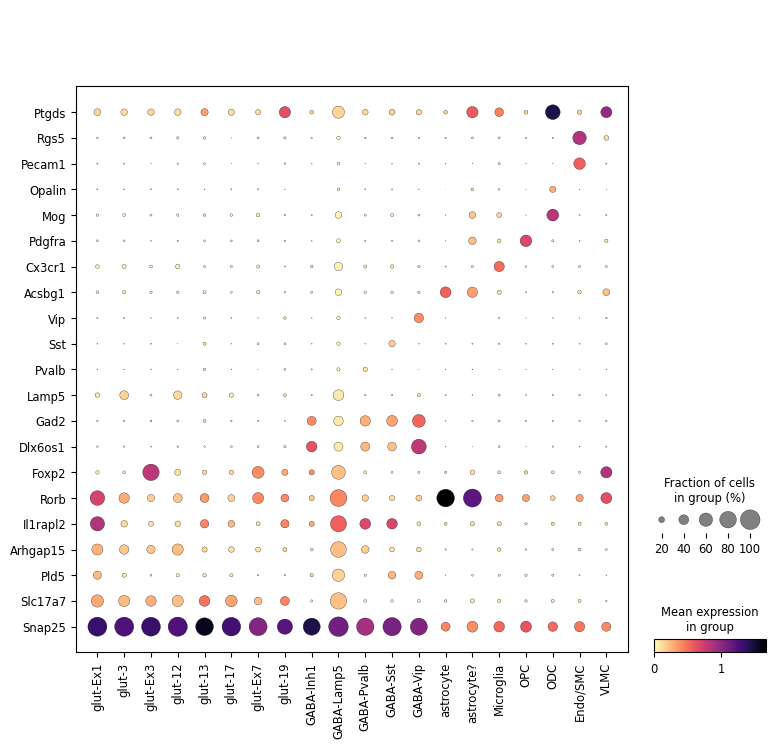

In [182]:
sc.pl.dotplot(adata, var_names=paper_markers, groupby="annot", swap_axes=True, cmap="magma_r", categories_order=paper_order)

In [186]:
adata.var["selected"] = adata.var["selected"].fillna(False)

/var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T/ipykernel_69131/347878662.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.var["selected"] = adata.var["selected"].fillna(False)


In [187]:
adata.write_h5ad("saline.h5ad")